# Convolutional Neural Networks: Step by Step

Implement convolutional and pooling layers in numpy

In [59]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%reload_ext autoreload
%autoreload 2

np.random.seed(1)

# 1 - Outline of the Assignment

![image](https://wx1.sinaimg.cn/mw1024/701c57e5gy1gdr7xpxomsj20xk0bejtc.jpg)

```html
Convolution functions, including:
    Zero Padding
    Convolve window
    Convolution forward
    Convolution backward (optional)

Pooling functions, including:
    Pooling forward
    Create mask
    Distribute value
    Pooling backward (optional)
```

# 2 - Convolutional Neural Networks

![image](https://wx4.sinaimg.cn/mw690/701c57e5gy1gdrb9jlb1wj20qe0d63z3.jpg)

## 2.1 - Zero Padding

Add zeros around the border of an image
![image](https://wx1.sinaimg.cn/mw690/701c57e5gy1gdrb9kp5mhj20vw0qan55.jpg)


Benefits:
- use a CONV Layer **without shrinking** the height and width
- **keep more information at the border** of an image

Exercise:
- [np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html)


In [60]:
a = np.ones(shape = (1, 1))
print(a)

# (0, 3)上不补, 下补3个
# (2, 1)左补2个, 右补1个
print(np.pad(a, ((0, 3), (2, 1)), 'constant', constant_values = 0))

[[1.]]
[[0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [61]:
def zero_pad (X, padding):
    """
    eg:
    X.shape = 3 * 3
    padding = 1
    X_padding = (3 + 2) * (3 + 2) = 5 * 5
    """
    pad_width = ((0, 0), (padding, padding), (padding, padding), (0, 0))
    return np.pad(X, pad_width, 'constant', constant_values = 0)

X.shape:  (4, 3, 3, 2)
X_pad.shape:  (4, 5, 5, 2)


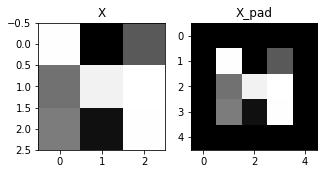

In [62]:
np.random.seed(1)
X = np.random.rand(4, 3, 3, 2)
X_pad = zero_pad(X, 1)
print('X.shape: ', X.shape)
print('X_pad.shape: ', X_pad.shape)

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('X')
axarr[0].imshow(X[0,:,:,0])
axarr[1].set_title('X_pad')
axarr[1].imshow(X_pad[0,:,:,0])

In [70]:
print(np.ones(shape = (2, 2, 3, 2)))

[[[[1. 1.]
   [1. 1.]
   [1. 1.]]

  [[1. 1.]
   [1. 1.]
   [1. 1.]]]


 [[[1. 1.]
   [1. 1.]
   [1. 1.]]

  [[1. 1.]
   [1. 1.]
   [1. 1.]]]]


## 2.2 - Single step of convolution

![image](https://wx3.sinaimg.cn/large/701c57e5gy1gdrb9k3i2qg20em0aojsv.gif)

* Weights = Filter: 3 * 3
* a_slice_prev: 图片的某个3 * 3 区域


```python
np.sum(a_slice_prev * Weights + bias)
```

In [73]:
def conv_single_step (a_slice_prev, W, b):
    # s = 对应位置相乘 + b
    s = a_slice_prev * W + b
    Z = np.sum(s)
    return Z

np.random.seed(1)

a_slice_prev = np.random.rand(3, 3, 3)
W = np.random.randn(3, 3, 3) # Filter_size * Filter_numbers
b = np.random.randn(1, 1, 1)

print('Z:', conv_single_step (a_slice_prev, W, b))

Z: -4.051739542293802


## 2.3 - Forward Pass

$A[0:2, 0:2, :]$

$A[x, y, z]$
* x取0,1位置
* y取0,1位置
* z取全部

![image](https://wx1.sinaimg.cn/mw1024/701c57e5gy1gds525jgrsj20s80ks76f.jpg)

* `f: filter = weights`: 权重 / 过滤器 (找到图像edge)
* `s: stride`: 移动步长
* `p: padding`: zero padding in corner of an image
* `n_C = number of filters you use`

最后输出的图像尺寸
$$n_H = \frac{n_{Hprev} + 2 * p - f}{s} + 1$$
$$n_W = \frac{n_{Wprev} + 2 * p - f}{s} + 1$$
$$n_C$$

![image](https://wx4.sinaimg.cn/mw1024/701c57e5ly1gdq7c03q5lj216m0nkdx7.jpg)
- 一个filter是 $f * f * n_c^{[l - 1]}$
- 本层有$n_c^{[l]}$, filter 尺寸 * 数量 = $f * f * n_c^{[l - 1]} * n_c^{[l]}$

![image](https://wx3.sinaimg.cn/mw1024/701c57e5gy1gds5267mvej21g00u0n3f.jpg)

![image](https://wx3.sinaimg.cn/mw1024/701c57e5gy1gds525zf6uj219o0swwj0.jpg)

In [132]:
def conv_forward (A_prev, W, b, hyperparameters):
    # A_prev (10, 4, 4, 3)
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # W: (f, f, n_C_prev)一个filter尺寸, n_C filter数量  (2, 2, 3, 8)
    (f, f, n_C_prev, n_C) = W.shape

    # hyperparameters
    padding = hyperparameters['padding']
    stride = hyperparameters['stride']
    
    # 1. OUTPUT (use int to floor)
    n_H = int((n_H_prev + 2 * padding - f) / stride) + 1
    n_W = int((n_W_prev + 2 * padding - f) / stride) + 1
    
    # 2. INIT Z
    Z = np.ones(shape = (m, n_H, n_W, n_C))
    
    # 3. INIT A_prev after padding
    # A_prev = (10, 4, 4, 3), A_prev_padding = (10, 4 + 2 * p, 4 + 2 * p, 3) = (10, 8, 8, 3)
    A_prev_padding = zero_pad(A_prev, padding)
    
    # 4. Samples_number
    for i in range(m):
        # 4.1 - 第i个样本值
        a_prev_padding = A_prev_padding[i] # 8 * 8 * 3
        
        # 4.2 - vertical axis
        for h in range(n_H):
            # 4.3 - horizontal axis
            for w in range(n_W):
                # 4.4 - filter_numbers 开始针对一个filter的计算
                for c in range(n_C):
                    # 4.5 选块
                    vertical_start = w * stride
                    vertical_end = vertical_start + f
                    horizontal_start = h * stride
                    horizontal_end = horizontal_start + f
                    
                    a_slice_prev = a_prev_padding[
                        vertical_start: vertical_end, 
                        horizontal_start: horizontal_end,
                        :
                    ]
                    
                    # 这一面filter的计算
                    Z[i, h, w, c] = conv_single_step (a_slice_prev, W[...,c], b[...,c])    
                    
    return Z             

In [133]:
# 有10个样本, 4 * 4 * 3 图片尺寸 (n_c_prev = 3)
# A_prev = np.random.randn(10, 4, 4, 3)
A_prev = np.random.randn(10, 4, 4, 3)
# f = 2 (2 * 2 * 3) (n_c = 1)

W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hyperparameters = {"padding" : 2, "stride": 1}

"""
m: samples number (10)
A: n_W_prev * n_H_prev * n_C_prev (4, 4, 3)

f: f * f * n_C_prev (2, 2, 3)
filters_num: n_C (8)
"""

Z = conv_forward (A_prev, W, b, hyperparameters)
print('Z.shape: ', Z.shape)

Z.shape:  (10, 7, 7, 8)


## 2. 3 - Forward Pooling

$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$
$$ n_C = n_{C_{prev}}$$

![image](https://github.com/Kulbear/deep-learning-coursera/raw/997fdb2e2db67acd45d29ae418212463a54be06d/Convolutional%20Neural%20Networks/images/max_pool1.png)

In [180]:
def pool_forward (A_prev, hyperparameters, mode = 'max'):
    # A_prev
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # hyperparameters
    f = hyperparameters['filter'] # f * f * n_C_prev
    s = hyperparameters['stride']
    
    # output_size
    n_H = int((n_H_prev - f) / s) + 1
    n_W = int((n_W_prev - f) / s) + 1
    n_C = n_C_prev
    
    A = np.zeros(shape = (m, n_H, n_W, n_C))
    # 样本数
    for i in range(m):
        A_prev_current = A_prev[i]
        # 一列
        for h in range(n_H):
            # 一行
            for w in range(n_W):
                # filter number
                for c in range(n_C):
                    w_start = w * s
                    w_end = w_start + f
                    h_start = h * s
                    h_end = h_start + f
                    # 第c个filter的区域内容
                    # ====== 这里没有想通 ======
                    A_prev_slice = A_prev_current[w_start: w_end, h_start: h_end, c]
                    
                    if mode == 'max':
                        A[i, h, w, c] = np.max(A_prev_slice)
                    elif mode == 'average':
                        A[i, h, w, c] = np.mean(A_prev_slice)
    return A

In [183]:
np.random.seed(1)
A_prev = np.random.randn(1, 4, 4, 3)
hyperparameters = {'stride': 2, 'filter': 2}
A = pool_forward (A_prev, hyperparameters, mode = 'max')
print('After Pool.....', A.shape)

After Pool..... (1, 2, 2, 3)
